# Burr Demo - observing state 
# & traveling back in time!


<img src="https://github.com/user-attachments/assets/2ab9b499-7ca2-4ae9-af72-ccc775f30b4e" width="100" align="left" /> + 
<img src="https://cdn.mos.cms.futurecdn.net/VgGxJABA8DcfAMpPPwdv6a.jpg" width="200" align="center"/>

[https://github.com/dagworks-inc/burr](https://github.com/dagworks-inc/burr) by DAGWorks Inc. (YCW23 & StartX).

Take🏠:

 - high level what is Burr
 - what you can do with Burr (observing state & being able to debug a particular point in time)
 - watch a walkthrough of this [notebook here](https://youtu.be/hqutVJyd3TI).

# Agentic Problems

## 1. Why did this LLM call fail?
## 2. Oh crap my code broke, why?
## 3. Things went off the rails, but where?
## 4. etc

# Monitoring FTW, right?

## Well but ... monitoring doesn't help you debug & complete your dev loop

## 1. How do I debug that quickly?

## 2. How do I fix the inputs/code, and restart my agent?

## 3. What if my agent was 20+ steps in … do I have to restart from step 0? or can I go to a specific point in time?

# Solution: Burr
(Complements our other framework [Hamilton](https://github.com/dagWorks-Inc/hamilton))


In [ ]:
# install libs if you need them
!pip install "burr[start]" openai opentelemetry-instrumentation-openai

## 1. Agent application is modeled as State + Actions --> Graph
Straightforward multi-modal example below:

In [49]:
import copy

from IPython.display import Image, display
from IPython.core.display import HTML 
import openai

from burr.core import ApplicationBuilder, State, default, graph, when
from burr.core.action import action
from burr.tracking import LocalTrackingClient

MODES = {
    "answer_question": "text",
    "generate_image": "image",
    "generate_code": "code",
    "unknown": "text",
}


@action(reads=[], writes=["chat_history", "prompt"])
def process_prompt(state: State, prompt: str) -> State:
    result = {"chat_item": {"role": "user", "content": prompt, "type": "text"}}
    state = state.append(chat_history=result["chat_item"])
    state = state.update(prompt=prompt)
    return state


@action(reads=["prompt"], writes=["mode"])
def choose_mode(state: State) -> State:
    prompt = (
        f"You are a chatbot. You've been prompted this: {state['prompt']}. "
        f"You have the capability of responding in the following modes: {', '.join(MODES)}. "
        "Please respond with *only* a single word representing the mode that most accurately "
        "corresponds to the prompt. Fr instance, if the prompt is 'draw a picture of a cat', "
        "the mode would be 'generate_image'. If the prompt is "
        "'what is the capital of France', the mode would be 'answer_question'."
        "If none of these modes apply, please respond with 'unknown'."
    )
    
    llm_result = openai.Client().chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
    )
    content = llm_result.choices[0].message.content
    mode = content.lower()
    if mode not in MODES:
        mode = "unknown"
    result = {"mode": mode}
    return state.update(**result)


@action(reads=["prompt", "chat_history"], writes=["response"])
def prompt_for_more(state: State) -> State:
    result = {
        "response": {
            "content": "None of the response modes I support apply to your question. "
                       "Please clarify?",
            "type": "text",
            "role": "assistant",
        }
    }
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def chat_response(
        state: State, prepend_prompt: str, model: str = "gpt-3.5-turbo"
) -> State:
    
    chat_history = copy.deepcopy(state["chat_history"])
    chat_history[-1]["content"] = f"{prepend_prompt}: {chat_history[-1]['content']}"
    chat_history_api_format = [
        {
            "role": chat["role"],
            "content": chat["content"],
        }
        for chat in chat_history
    ]
    client = openai.Client()
    result = client.chat.completions.create(
        model=model,
        messages=chat_history_api_format,
    )
    text_response = result.choices[0].message.content
    result = {"response": {"content": text_response, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def image_response(state: State, model: str = "dall-e-2") -> State:
    """Generates an image response to the prompt. Optional save function to save the image to a URL."""
    raise ValueError("Demo error")
    client = openai.Client()
    result = client.images.generate(
        model=model, prompt=state["prompt"], size="1024x1024", quality="standard", n=1
    )
    image_url = result.data[0].url
    result = {"response": {"content": image_url, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["response", "mode"], writes=["chat_history"])
def response(state: State) -> State:
    # you'd do something specific here based on prior state
    result = {"chat_item": state["response"]}
    return state.append(chat_history=result["chat_item"])


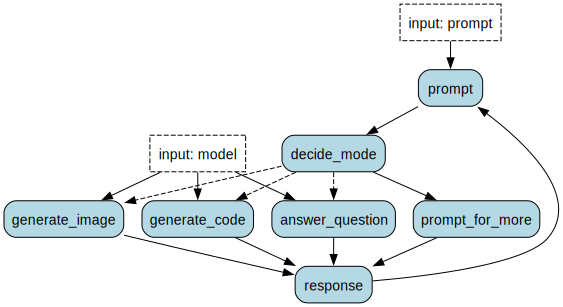

In [50]:
# Built the graph.
base_graph = (
    graph.GraphBuilder()
    .with_actions(
        # these are the "nodes" 
        prompt=process_prompt,
        decide_mode=choose_mode,
        generate_image=image_response,
        generate_code=chat_response.bind(
            prepend_prompt="Please respond with *only* code and no other text (at all) to the following:",
        ),
        answer_question=chat_response.bind(
            prepend_prompt="Please answer the following question:",
        ),
        prompt_for_more=prompt_for_more,
        response=response,
    )
    .with_transitions(
        # these are the edges between nodes, based on state.
        ("prompt", "decide_mode", default),
        ("decide_mode", "generate_image", when(mode="generate_image")),
        ("decide_mode", "generate_code", when(mode="generate_code")),
        ("decide_mode", "answer_question", when(mode="answer_question")),
        ("decide_mode", "prompt_for_more", default),
        (
            ["generate_image", "answer_question", "generate_code", "prompt_for_more"],
            "response",
        ),
        ("response", "prompt", default),
    )
    .build()
)
base_graph.visualize()

## 2. Build application --> built in checkpointing & tracking

Attempting to instrument while already instrumented


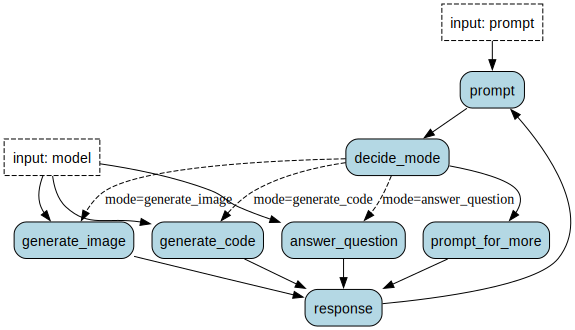

In [51]:
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
# this will auto instrument the openAI client. No swapping of imports required!
OpenAIInstrumentor().instrument()

tracker = LocalTrackingClient(project="agent-demo-otel")
app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker, 
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
    )
    # .with_identifiers(app_id=, partition_key=)
    .with_tracker(tracker, use_otel_tracing=True)  # tracking + checkpointing; one line 🪄.
    .build()
)
app

## 3. Comes with a UI
View runs in the UI; Let's run the app first.

In [ ]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? write hello world in java


🤖: public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}


[Open the UI - http://localhost:7241/](http://localhost:7241)


## But something broke / I want to debug

Use:

* Application ID

In [35]:
app_id = "8903a1b8-731b-4dea-8372-b915244875e3"

In [36]:
resumed_app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker,
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
    )
    .with_tracker(tracker, use_otel_tracing=True)
    .with_identifiers(app_id=app_id)
    .build()
)

In [37]:
resumed_app.state["chat_history"]

[{'role': 'user', 'content': 'draw me a picture of a cat', 'type': 'text'}]

In [38]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = resumed_app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? 


Hi, how can I help? quit


## Actually what if I want to go back to a certain point in time?

* Fork: Start with state from any checkpoint

In [39]:
app_id = "8903a1b8-731b-4dea-8372-b915244875e3"
sequence_id = 1
# partition_key = ""

In [40]:
forked_app = (
    ApplicationBuilder()
    .with_graph(base_graph) # this could be different...
    .initialize_from(
        tracker,
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
        fork_from_app_id=app_id,
        fork_from_sequence_id=sequence_id,
        # fork_from_partition_key=partition_key
    )
    .with_tracker(tracker)
    .build()
)

In [41]:
# show prior forked state
forked_app.state["chat_history"]

[{'role': 'user', 'content': 'draw me a picture of a cat', 'type': 'text'}]

In [42]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = forked_app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? 


Hi, how can I help? quit


# Want to know more?

[Link to video walking through this notebook](https://youtu.be/hqutVJyd3TI).

[https://github.com/dagworks-inc/burr](https://github.com/dagworks-inc/burr)
<img src="burr_qrcode.png" width="125"/>

[Time Travel blog post & video:](https://blog.dagworks.io/p/travel-back-in-time-with-burr)

<a href="https://www.youtube.com/embed/98vxhIcE6NI?si=oV1BbSUCKa1UvX5P"><img src="https://img.youtube.com/vi/98vxhIcE6NI/0.jpg"> 
</img>
<a href="https://www.youtube.com/embed/98vxhIcE6NI?si=oV1BbSUCKa1UvX5P">

More blogs @ `blog.dagworks.io` e.g. [async & streaming](https://blog.dagworks.io/p/streaming-chatbot-with-burr-fastapi)

More [examples](https://github.com/DAGWorks-Inc/burr/tree/main/examples/):

- e.g. [test case creation](https://burr.dagworks.io/examples/creating_tests/)
- e.g. [multi-agent collaboration](https://github.com/DAGWorks-Inc/burr/tree/main/examples/multi-agent-collaboration)

Follow on Twitter & LinkedIn:

- https://x.com/burr_framework
- https://x.com/dagworks
- https://x.com/stefkrawczyk
- https://www.linkedin.com/in/skrawczyk/

In [15]:
!burr-test-case create  \
  --project-name "agent-demo-otel" \
  --partition-key "null" \
  --app-id "1f983e4e-25d3-4ed1-b985-569131603f34" \
  --sequence-id 14 \
  --target-file-name YOUR_FIXTURE_FILE.json


Found data for action:  generate_code

Writing data to file YOUR_FIXTURE_FILE.json

Add the following to your test file:

import pytest
from burr.core import state
from burr.testing import pytest_generate_tests  # noqa: F401
# TODO: import action you're testing, i.e. import generate_code.

@pytest.mark.file_name("YOUR_FIXTURE_FILE.json")
def test_generate_code(input_state, expected_state):
    """Function for testing the action"""
    input_state = state.State.deserialize(input_state)
    expected_state = state.State.deserialize(expected_state)
    _, output_state = generate_code(input_state)  # exercise the action
    # TODO: choose appropriate way to evaluate the output
    # e.g. exact match, fuzzy match, LLM grade, etc.
    # this is exact match here on all values in state
    assert output_state == expected_state
    # e.g.
    # assert 'some value' in output_state["response"]["content"]
    # assert llm_evaluator(..., ...) == "Y"

